# Forward Testing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [ ]:
# Version 6.0 (Leverage)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    add_leverage:
        adds leverage to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
            
    def plot_results(self, leverage = False):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        elif leverage:
            title = "{} | Window = {} | Frequency = {} | TC = {} | Leverage = {}".format(self.symbol, self.window, self.freq, self.tc, self.leverage)
            self.results[["creturns", "cstrategy", "cstrategy_levered"]].plot(title=title, figsize=(12, 8))
        else:
            title = "{} | Window = {} | Frequency = {} | TC = {}".format(self.symbol, self.window, self.freq, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True):
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session", group_keys = False).apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
        
    def add_leverage(self, leverage, sl = -0.5, report = True):
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        sl: float (negative), default -50% (regulatory)
            maximum margin loss level in % (e.g. -0.2 for -20%).
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        
        self.leverage = leverage
        sl_thresh = sl / leverage
        self.add_stop_loss(sl_thresh, report = False)
        
        data = self.results.copy()
        data["simple_ret"] = np.exp(data.strategy) - 1
        data["eff_lev"] = leverage * (1 + data.session_compound) / (1 + data.session_compound * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
        data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["strategy_levered"] = levered_returns
        data["cstrategy_levered"] = data.strategy_levered.add(1).cumprod()
        
        self.results = data
            
        if report:
            self.print_performance(leverage = True)
    ############################## Performance ######################################
    
    def print_performance(self, leverage = False):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        
        if leverage:
            to_analyze = np.log(data.strategy_levered.add(1))
        else: 
            to_analyze = data.strategy
        
        strategy_multiple = round(self.calculate_multiple(to_analyze), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(to_analyze), 6)
        ann_mean =          round(self.calculate_annualized_mean(to_analyze), 6)
        ann_std =           round(self.calculate_annualized_std(to_analyze), 6)
        sharpe =            round(self.calculate_sharpe(to_analyze), 6)
        sortino =           round(self.calculate_sortino(to_analyze), 6)
        max_drawdown =      round(self.calculate_max_drawdown(to_analyze), 6)
        calmar =            round(self.calculate_calmar(to_analyze), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(to_analyze), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(to_analyze), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

__Scenario__: <br>
It´s the __end of 2018__. __Define and optimize__ a simple Contrarian Strategy for EUR/USD __based on 2018__ data. <br>
__Forward Test the Strategy on 2019 data__.

## Backtesting / Forward Testing  - a simple (too simple?) approach

### Backtesting 2018

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2018-12-31"
ptc = 0.00007

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

In [61]:
tester.optimize_strategy((51, 301, 5), (51, 301, 5), metric = "Multiple") # finding the best combination freq/windows 

KeyboardInterrupt: 

In [ ]:
tester.visualize_many()

In [ ]:
leverage = np.arange(1, 30, 1)
leverage

In [ ]:
multiple = []
for lever in leverage:
    tester.add_leverage(leverage = lever, sl = -0.4, report = False)
    multiple.append(tester.results.cstrategy_levered[-1])
results = pd.DataFrame(data = {"Leverage": leverage, "Multiple":multiple}) 

In [ ]:
results.set_index("Leverage", inplace = True)
results

In [ ]:
results.plot(figsize = (12, 8));
plt.show()

In [ ]:
tester.test_strategy(201, 101)

In [ ]:
tester.plot_results()

In [ ]:
tester.add_leverage(leverage = 27, sl = -0.4)

In [ ]:
tester.plot_results(leverage = True)

### Forward Testing 2019

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2019-01-01"
end = "2019-12-31"
ptc = 0.00007

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

In [ ]:
tester.test_strategy(201, 101)

In [ ]:
tester.plot_results()

In [ ]:
tester.add_leverage(leverage = 13, sl = -0.4)

In [ ]:
tester.plot_results(leverage = True)

> Leverage should not exceed "Half Kelly" of Backtesting.

## The Performance of Strategies over multiple Time Periods

Problem: Single Period Backtest has lots of random noise. 

Desired Property of a good strategy: it __performs stable and well over multiple periods__. 

-> Split 2018 into subperiods (quarters) and run __separate backtests__ for subperiods.
(remove/lower impact of random noise)

### Backtesting Period 2018

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"

start1 = "2018-01-01"
end1 = "2018-03-31"
start2 = "2018-04-01"
end2 = "2018-06-30"
start3 = "2018-07-01"
end3 = "2018-09-30"
start4 = "2018-10-01"
end4 = "2018-12-31"

ptc = 0.00007

__1. Quarter 2018__

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start1, end = end1, tc = ptc)
tester

In [ ]:
tester.optimize_strategy(freq_range = (51, 301, 5), window_range = (51, 301, 5), metric = "Multiple") # finding the best combination freq/windows 

In [ ]:
tester.visualize_many()

In [ ]:
q1 = tester.results_overview
q1

__2. Quarter 2018__

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start2, end = end2, tc = ptc)
tester

In [ ]:
tester.optimize_strategy(freq_range = (51, 301, 5), window_range = (51, 301, 5), metric = "Multiple") # finding the best combination freq/windows 

In [ ]:
tester.visualize_many()

In [ ]:
q2 = tester.results_overview
q2

__3. Quarter 2018__

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start3, end = end3, tc = ptc)
tester

In [ ]:
tester.optimize_strategy(freq_range = (51, 301, 5), window_range = (51, 301, 5), metric = "Multiple") # finding the best combination freq/windows 

In [ ]:
tester.visualize_many()

In [ ]:
q3 = tester.results_overview
q3

__4. Quarter 2018__

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start4, end = end4, tc = ptc)
tester

In [ ]:
tester.optimize_strategy(freq_range = (51, 301, 5), window_range = (51, 301, 5), metric = "Multiple") # finding the best combination freq/windows 

In [ ]:
tester.visualize_many()

In [ ]:
q4 = tester.results_overview
q4

__Comparing all four quarters__

In [ ]:
comp = pd.concat([q1, q2, q3, q4], axis = 1).iloc[:, [0, 1, 2, 5, 8, 11 ]]
comp

In [ ]:
comp["Score1"] = comp.iloc[:,2:].mean(axis = 1) # mean of multiples
comp

In [ ]:
comp.iloc[:, 2:6].rank(ascending = False)

In [ ]:
comp["Score2"] = (comp.iloc[:, 2:6].rank(ascending = False)**2).mean(axis = 1) # mean rank
comp

In [ ]:
comp.sort_values(by = "Score1", ascending = False).head(20)

In [ ]:
comp.sort_values(by = "Score2", ascending = True).head(20)

## Backtesting / Forward Testing a stable Strategy

In [62]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = "2018-01-01", end = "2018-12-31", tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2018-12-31)

In [63]:
tester.test_strategy(181, 106)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 181min | WINDOW = 106
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.160187
Multiple (Buy-and-Hold):     0.935635
--------------------------------------
Out-/Underperformance:       0.224552


CAGR:                        0.169817
Annualized Mean:             0.157523
Annualized Std:              0.07865
Sharpe Ratio:                2.002824
Sortino Ratio:               2.86007
Maximum Drawdown:            0.062707
Calmar Ratio:                2.708091
Max Drawdown Duration:       96 Days
Kelly Criterion:             25.964675


In [64]:
leverage = np.arange(1, 50, 1)
leverage

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [65]:
multiple = []
for lever in leverage:
    tester.add_leverage(leverage = lever, sl = -0.4, report = False)
    multiple.append(tester.results.cstrategy_levered[-1])
results = pd.DataFrame(data = {"Leverage": leverage, "Multiple":multiple})   

In [66]:
results.set_index("Leverage", inplace = True)
results

,Multiple
Leverage,
1,1.160187
2,1.341072
3,1.544299
4,1.771404
5,2.023733
6,2.302348
7,2.106881
8,2.505106
9,2.966130


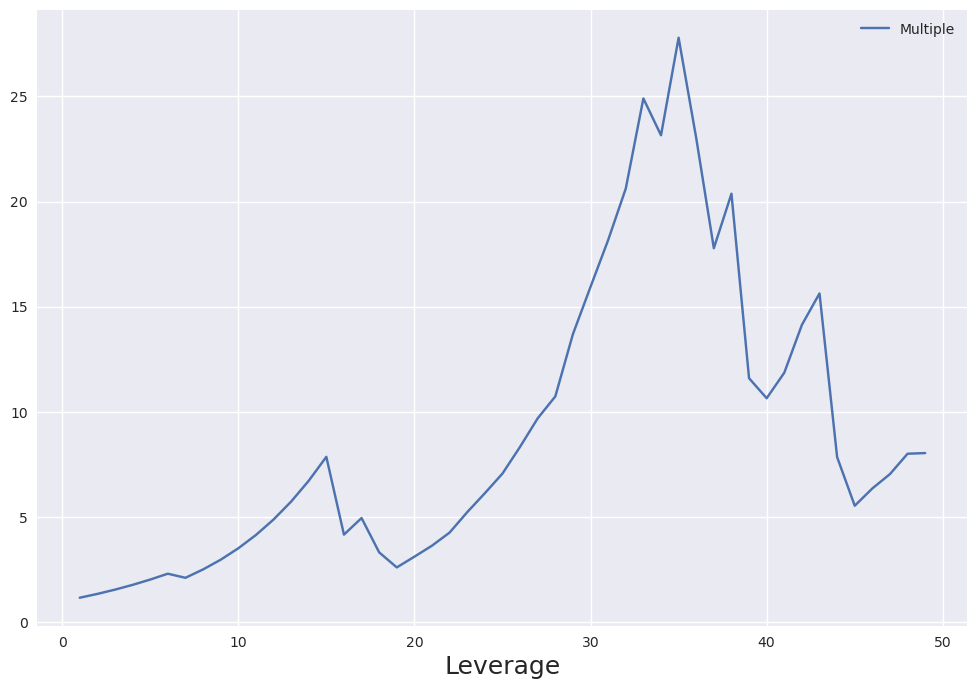

In [67]:
results.plot(figsize = (12, 8));
plt.show()

In [71]:
tester.test_strategy(181, 106)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 181min | WINDOW = 106
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.160187
Multiple (Buy-and-Hold):     0.935635
--------------------------------------
Out-/Underperformance:       0.224552


CAGR:                        0.169817
Annualized Mean:             0.157523
Annualized Std:              0.07865
Sharpe Ratio:                2.002824
Sortino Ratio:               2.86007
Maximum Drawdown:            0.062707
Calmar Ratio:                2.708091
Max Drawdown Duration:       96 Days
Kelly Criterion:             25.964675


In [72]:
tester.add_leverage(12, sl = -0.4)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 181min | WINDOW = 106
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         4.876543
Multiple (Buy-and-Hold):     0.935635
--------------------------------------
Out-/Underperformance:       3.940908


CAGR:                        4.325933
Annualized Mean:             1.679788
Annualized Std:              0.955181
Sharpe Ratio:                1.758607
Sortino Ratio:               2.503302
Maximum Drawdown:            0.464383
Calmar Ratio:                9.315442
Max Drawdown Duration:       143 Days
Kelly Criterion:             2.341017


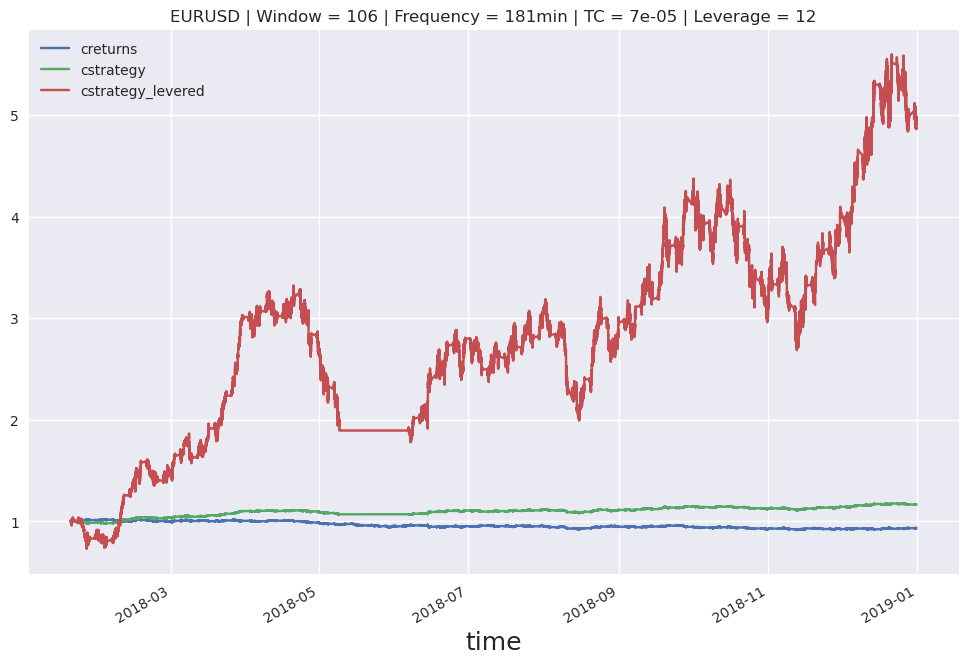

In [73]:
tester.plot_results(leverage=True)

__Forward Testing__

In [74]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = "2019-01-01", end = "2019-12-31", tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2019-01-01, end = 2019-12-31)

In [75]:
tester.test_strategy(181, 106)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 181min | WINDOW = 106
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.094609
Multiple (Buy-and-Hold):     0.985544
--------------------------------------
Out-/Underperformance:       0.109065


CAGR:                        0.100738
Annualized Mean:             0.095877
Annualized Std:              0.054168
Sharpe Ratio:                1.769984
Sortino Ratio:               2.522276
Maximum Drawdown:            0.030563
Calmar Ratio:                3.296115
Max Drawdown Duration:       76 Days
Kelly Criterion:             33.175533


In [76]:
tester.add_leverage(12, sl = -0.4)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 181min | WINDOW = 106
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.687348
Multiple (Buy-and-Hold):     0.985544
--------------------------------------
Out-/Underperformance:       1.701804


CAGR:                        1.856568
Annualized Mean:             1.048478
Annualized Std:              0.670937
Sharpe Ratio:                1.562707
Sortino Ratio:               2.219991
Maximum Drawdown:            0.325229
Calmar Ratio:                5.7085
Max Drawdown Duration:       76 Days
Kelly Criterion:             2.829305


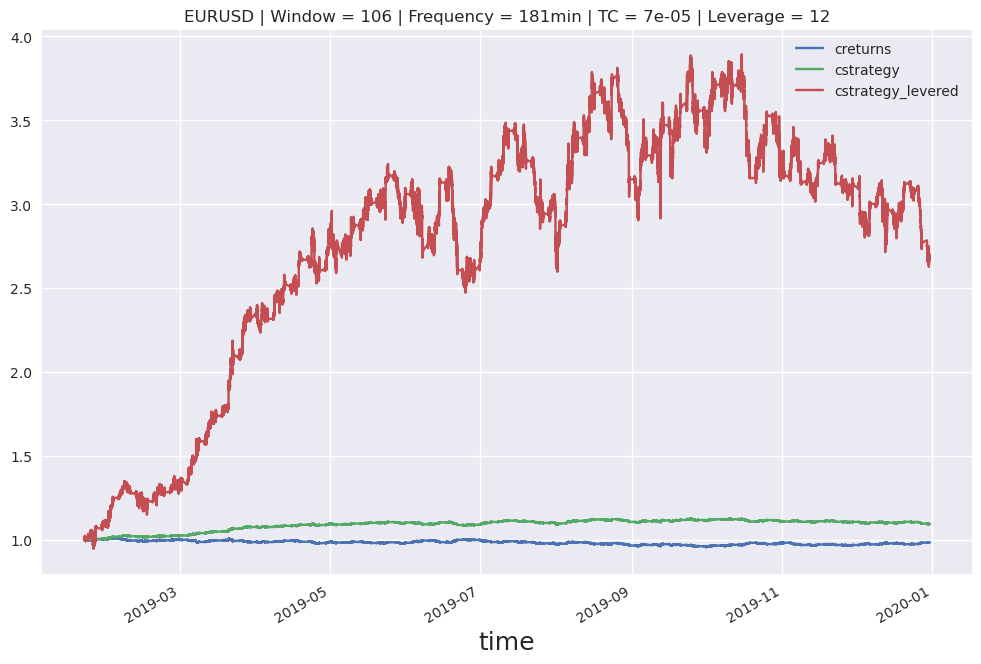

In [77]:
tester.plot_results(leverage=True)